import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from itertools import product
from stable_baselines3 import A2C
from pathlib import Path
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import time
import copy
from tqdm import trange
import os
import pandas as pd
import joblib
from copy import copy
from gym.wrappers import TimeLimit
from tqdm import tqdm, trange
from skmultiflow.lazy import KNNRegressor

In [1]:
from rl_ood import *

In [2]:
path = Path.cwd()
device = 'cpu'

# OOD environments instantiation

In [3]:
default_values, values = get_cartpole_values()

In [4]:
default_values

{'Gravity': 9.8,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 10.0}

In [5]:
def get_ood_configs(default_values, values):
    """
    Gives ood config that differ form the defalut config by only one value
    """
    ood_configs = []
    #changes = []
    for key in values:
        
        for value in values[key]:
            ood_config = copy(default_values)
            if value != default_values[key]:
                ood_config[key] = value
                ood_config['change'] = key
                ood_configs.append(ood_config)
                #changes.append({key:value})

    return ood_configs #, changes

ood_configs = get_ood_configs(default_values, values)
len(ood_configs)
ood_configs[0]

{'Gravity': 0.98,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 10.0,
 'change': 'Gravity'}

In [6]:
{'Force_magnitude': 70.0}.keys()

dict_keys(['Force_magnitude'])

In [7]:

ood_env = instanciate_cartpole(ood_configs[0])
print(ood_env)
ood_env.close()

<TimeLimit<CartPoleEnv<CartPole-v1>>>


In [8]:
def get_possible_combinaisons(values):
    return [x for x in product(*list(values.values()))]

# Evaluate OOD impact

### Original environment

In [9]:



def evaluate(env, agent, nb_episodes=100, render=False):
    total_rewards = []
    observation = env.reset()
    
    for ep in range(nb_episodes):
        total_reward = 0.0
        observation = env.reset()
        terminated = False
        
        while terminated is False:
            action, _state = agent.predict(observation)
            #action = env.action_space.sample()
            observation, reward, terminated, info = env.step(action)
            total_reward += reward

            if render:
                env.render()
                
        total_rewards.append(total_reward)

            
    env.close()
    
    return np.mean(total_rewards), np.std(total_rewards)



In [10]:
#agent = A2C.load(path/'Agents'/'Pendulum-v1.zip', env=env)

#agent = A2C.load(path/'Agents'/'CartPole-v1.zip', env=env)
env = instanciate_cartpole(default_values)

path_agent = path / 'Agents' / 'trained_CartPole_10000'
#if os.path.exists(path_agent):
#    agent = A2C.load(path_agent)
#else:
agent = A2C('MlpPolicy', env)
agent.learn(10000)
agent.save(path_agent)

evaluate(env, agent, nb_episodes=10, render=False)

(111.8, 31.666385963668162)

In [11]:
evaluate(env, agent, render=False)

(108.09, 33.33709495441977)

In [12]:
ood_configs[0]

{'Gravity': 0.98,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 10.0,
 'change': 'Gravity'}

In [13]:
default_values

{'Gravity': 9.8,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 10.0}

In [14]:
ood_env = instanciate_cartpole(ood_configs[0])
#agent = A2C.load(path/'Agents'/'CartPole-v1.zip', env=ood_env)
agent = A2C.load(path/'Agents'/'trained_CartPole_10000', env=ood_env)
evaluate(ood_env, agent, render=False)

(205.52, 64.29315360129725)

In [15]:
ood_env = instanciate_cartpole(ood_configs[-1])
print(ood_env.gravity)
evaluate(ood_env, agent, render=False)

9.8


(46.42, 36.13645804447359)

### Evaluation 

In [16]:
default_values, values = get_cartpole_values()
results = {}
std_results = {}

original_env = instanciate_cartpole(default_values)
agent = A2C.load(path/'Agents'/'trained_CartPole_10000', env=original_env)
original_result, original_std_result = evaluate(original_env, agent, render=False)

for config in tqdm(ood_configs):
    if config['change'] not in results:
        results[config['change']] = []
        std_results[config['change']] = []
    
    ood_env = instanciate_cartpole(config)
    agent = A2C.load(path/'Agents'/'trained_CartPole_10000', env=ood_env)
    mean_reward, std_reward = evaluate(ood_env, agent, nb_episodes=10)
    
    results[config['change']].append(mean_reward)
    std_results[config['change']].append(std_reward)
    #print(config, mean_reward)
    



100%|██████████| 90/90 [00:09<00:00,  9.92it/s]


In [17]:
L = copy(values['Gravity'])
L.append(9.8)
print(sorted(L))

[0.98, 1.09, 1.23, 1.4, 1.63, 1.96, 2.45, 3.27, 4.9, 9.8, 19.6, 29.4, 39.2, 49.0, 58.8, 68.6, 78.4, 88.2, 98.0]


In [18]:
original_result, original_std_result

(106.61, 30.294849397216026)

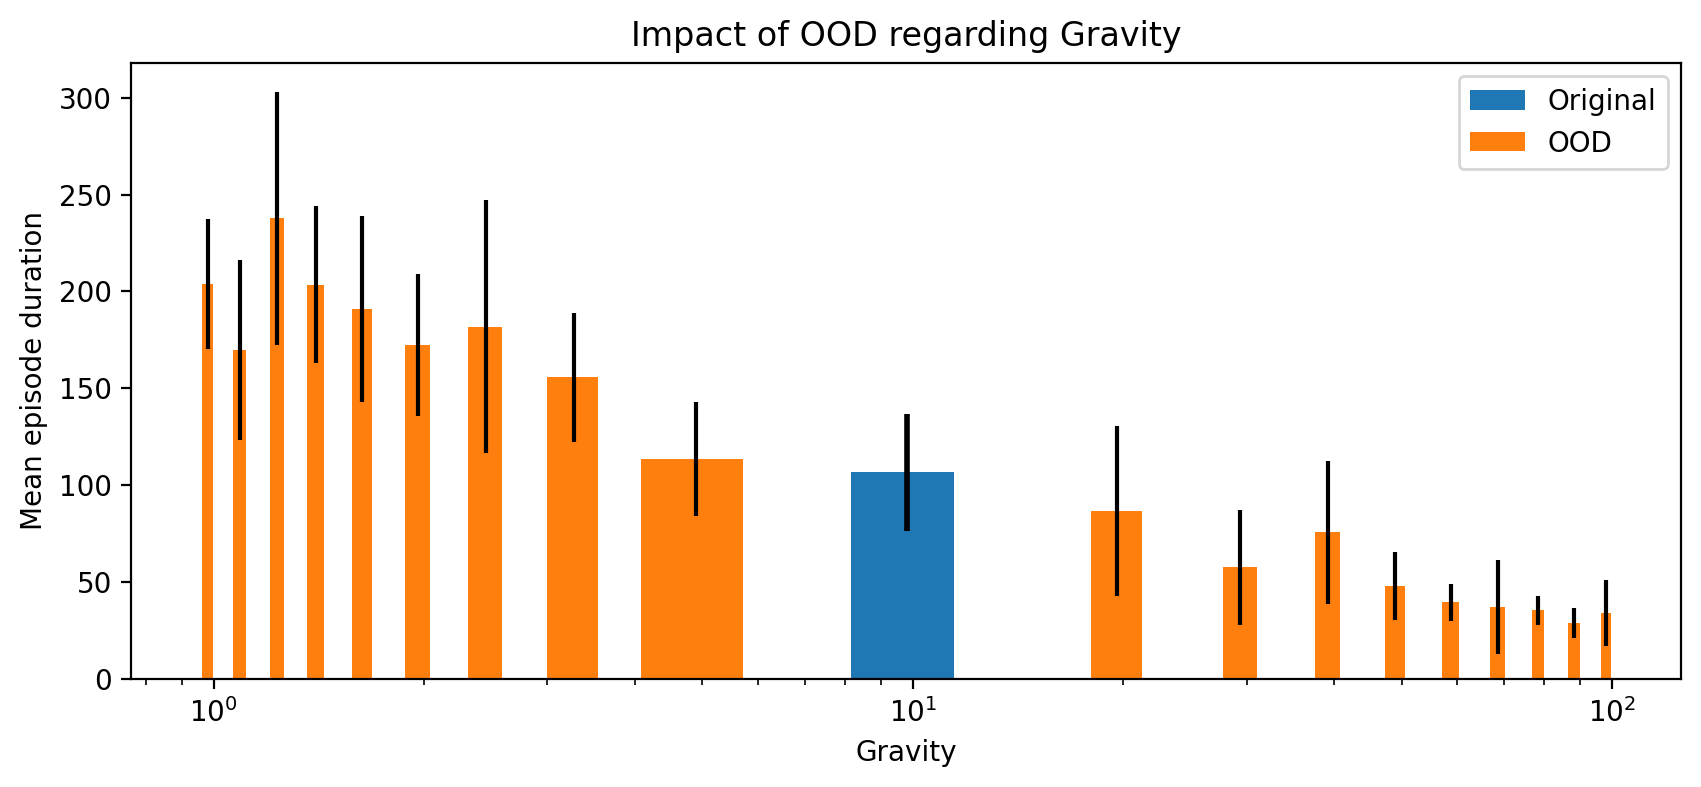

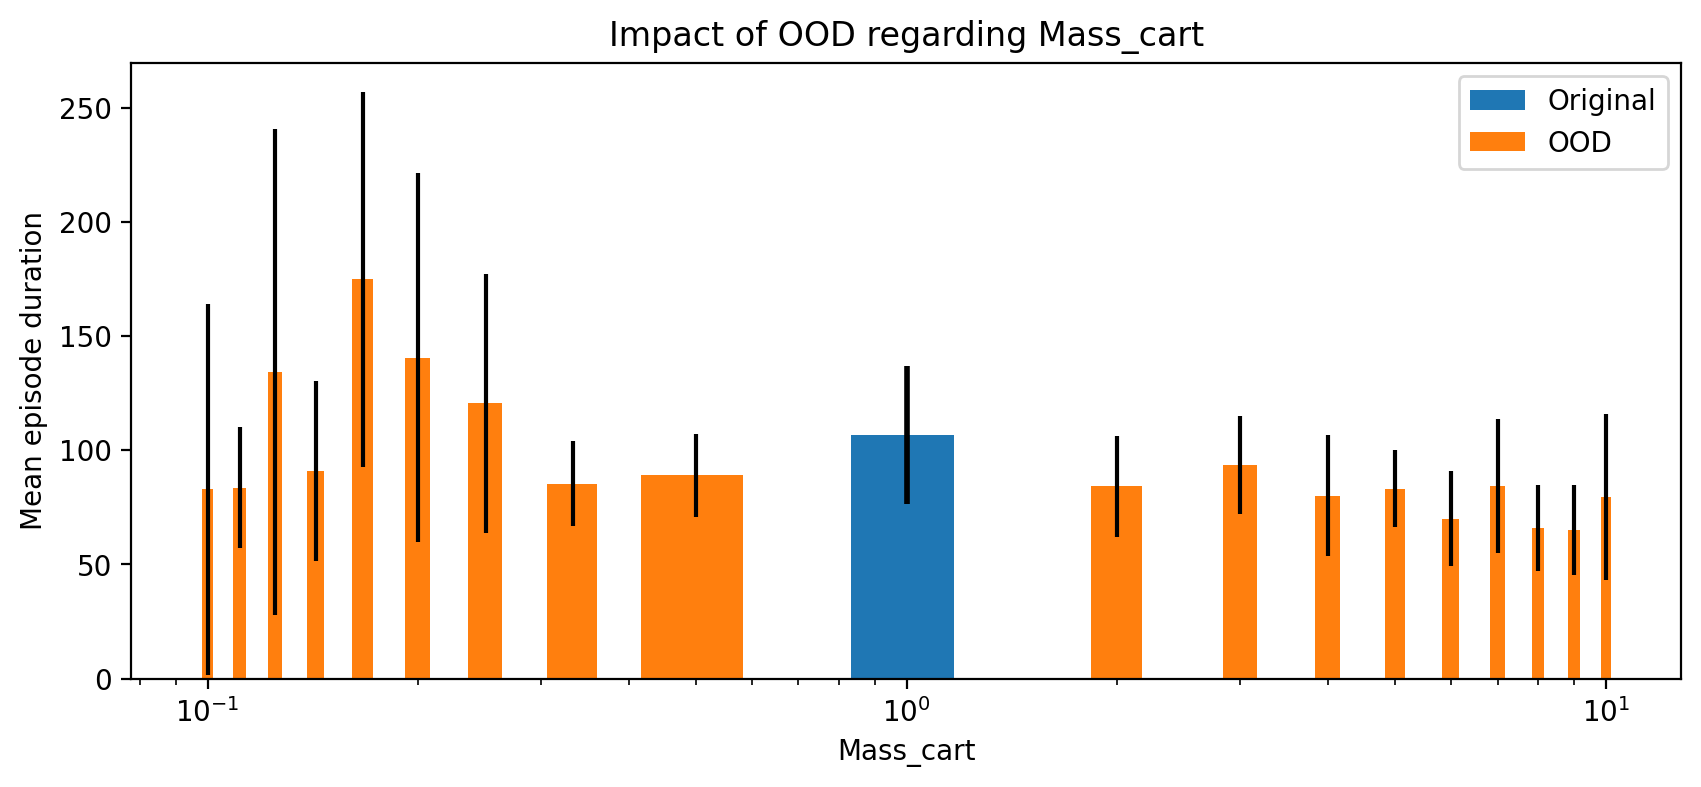

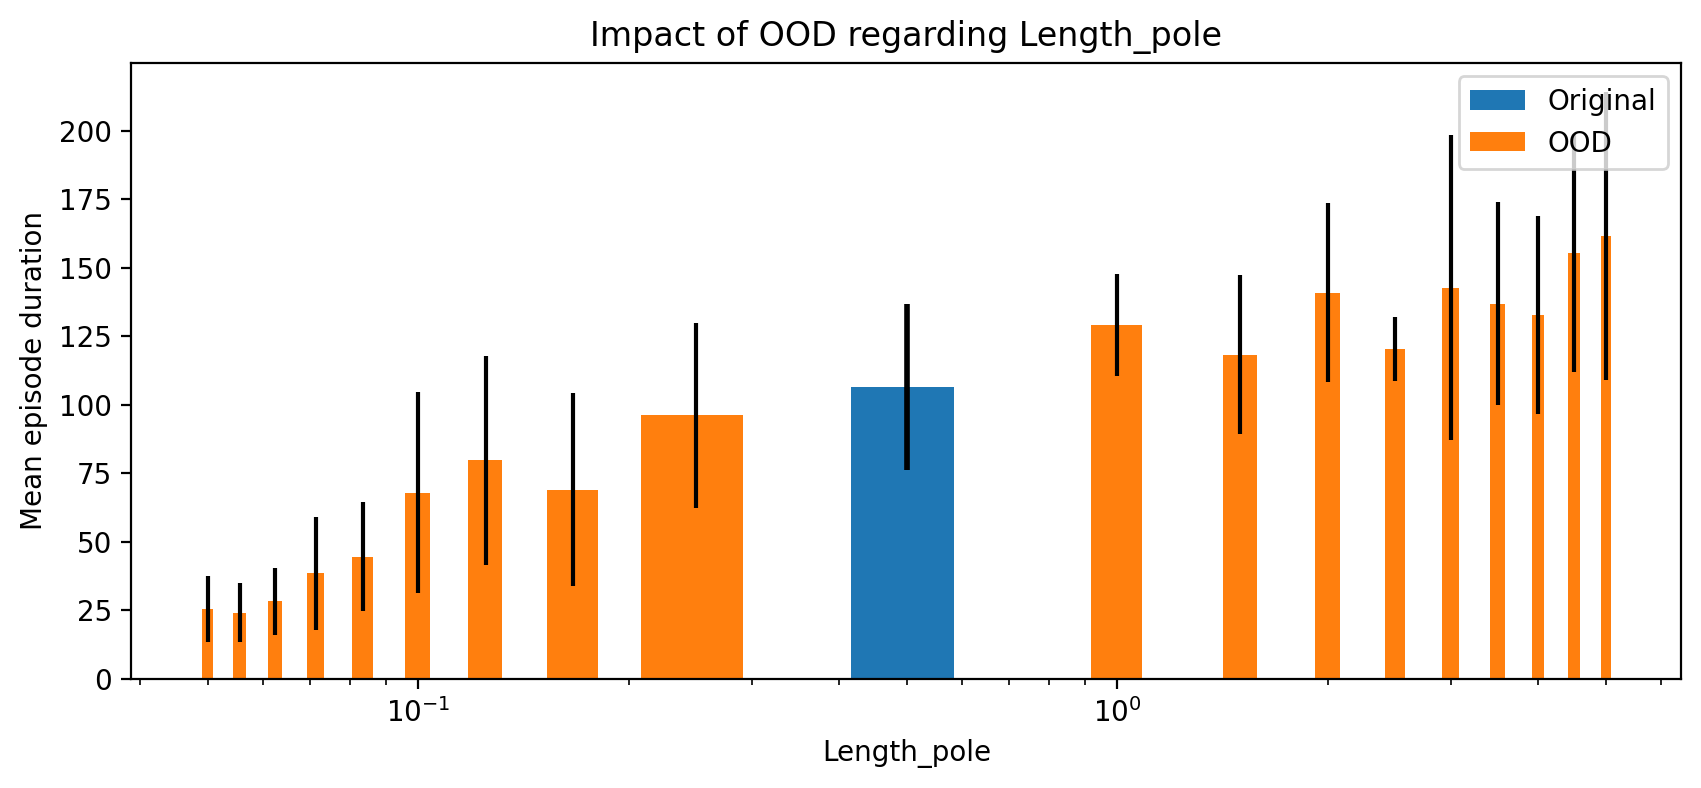

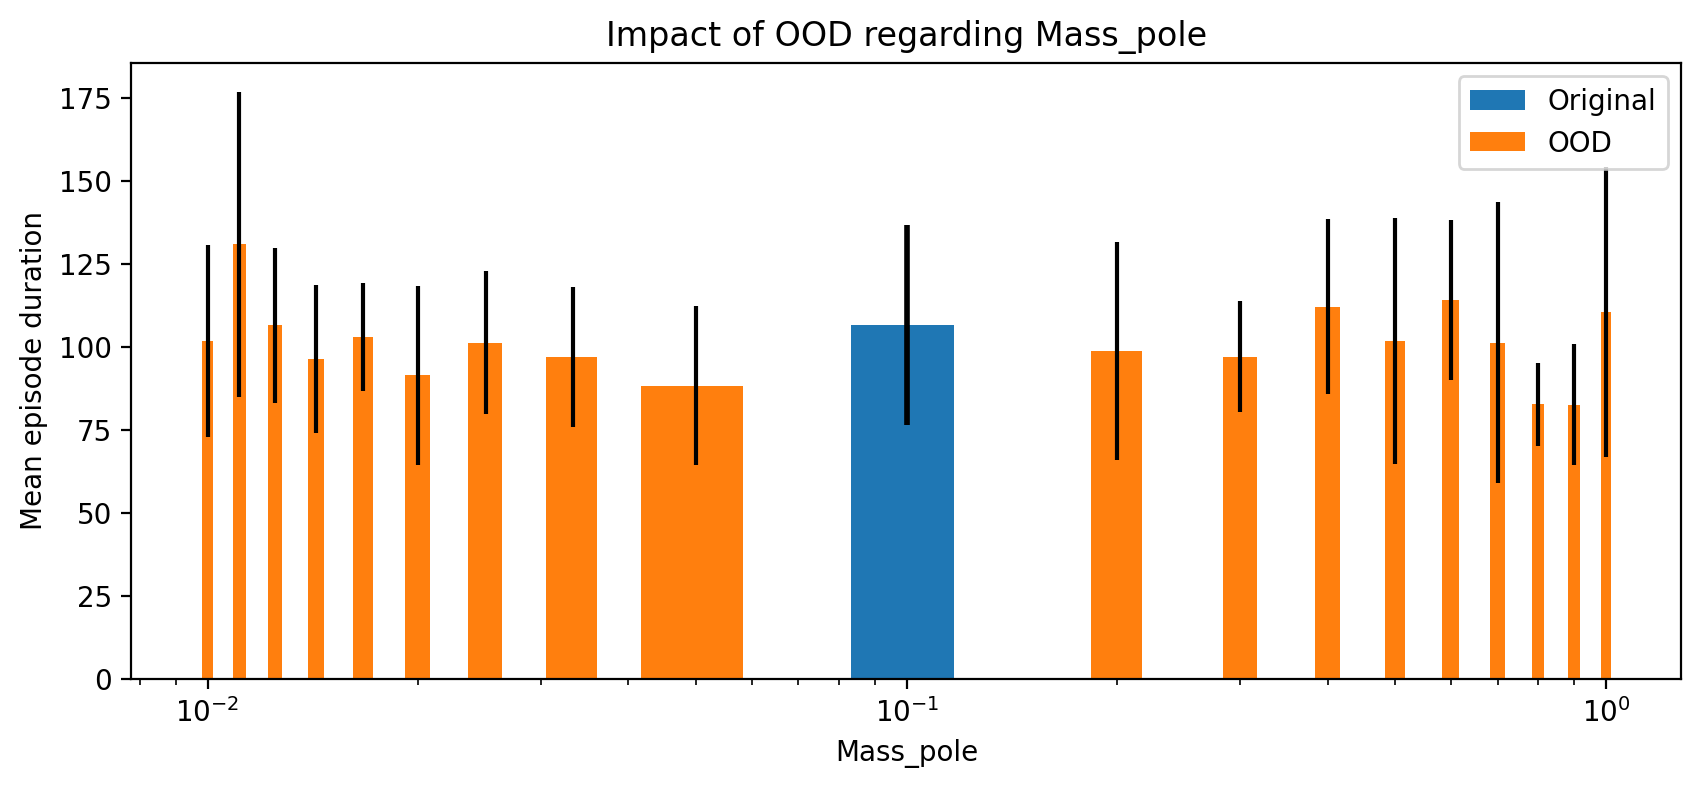

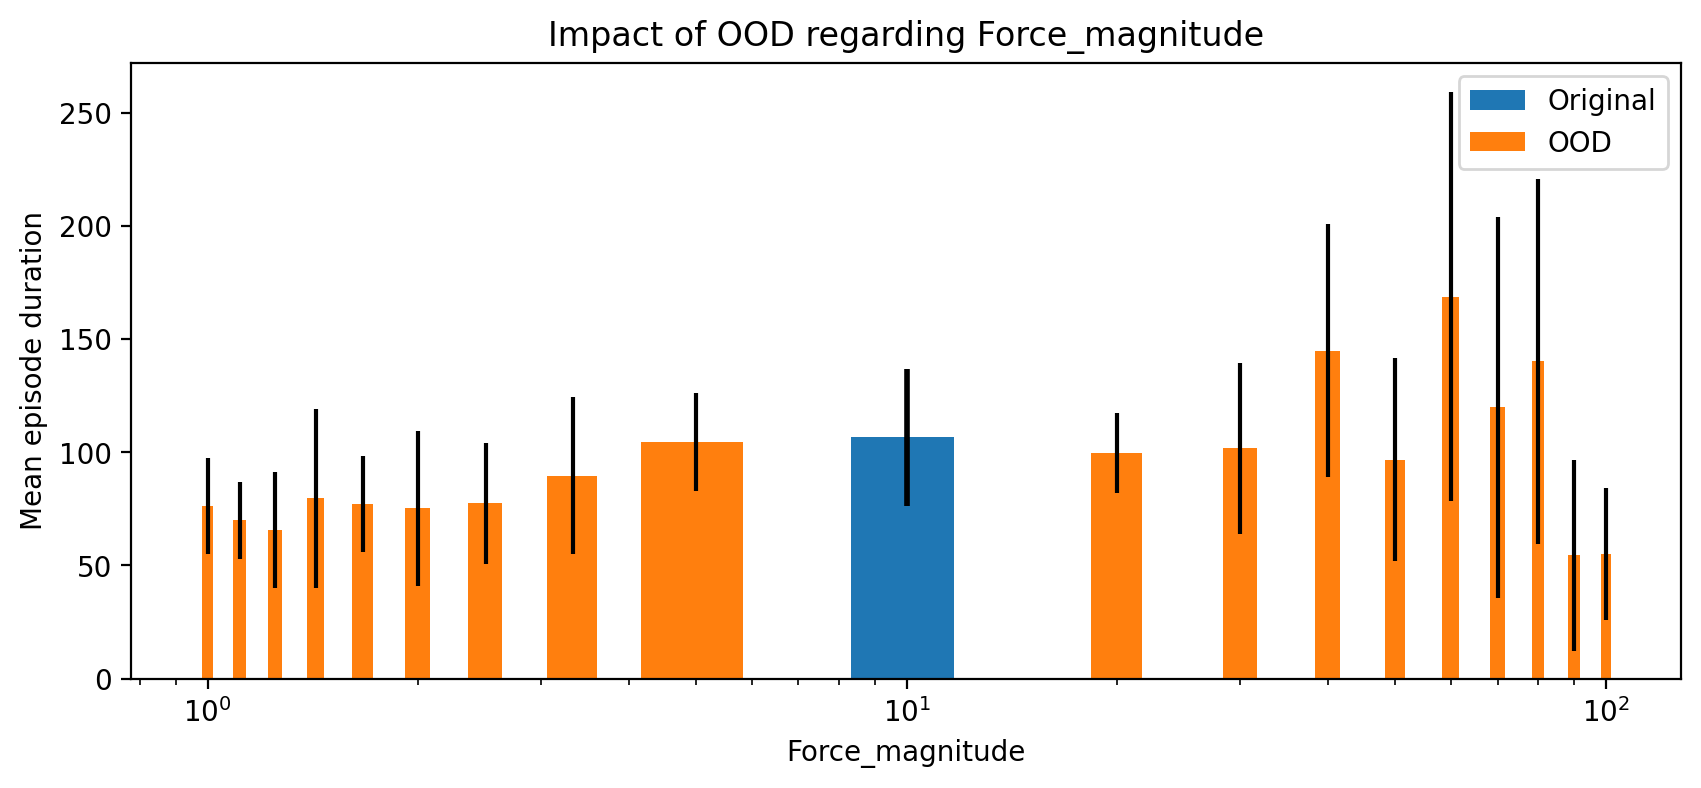

In [19]:
for key in results:
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    
    labels = copy(values[key])
    labels.append(default_values[key])
    labels = sorted(labels)
    
    width = np.array(labels[1:]) - np.array(labels[:-1]) 
    width /= 3
    #print(width, np.array([width[-1]]))
    #width = np.concatenate((width, np.array([width[-1]])))/ 5
    #print(width)
    ax.bar(default_values[key], original_result, yerr=original_std_result, width=width, label='Original')

    ax.bar(values[key], results[key], yerr=std_results[key], width=width, label='OOD')
    
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)
    ax.legend()
    """
    ax.bar(str(default_values[key]), original_result, width=width)
    labels = [str(x) for x in values[key]]
    ax.bar(labels, results[key], width=width)
    """
    

# Create OOD detector

In [20]:
default_values, values = get_cartpole_values()
env = instanciate_cartpole(default_values)
ood_detector = MartingaleOODDetector(env)

100%|██████████| 100/100 [00:00<00:00, 35308.56it/s]


Absolute error
Mean:  0.016291800218226852
Std:  0.04125975728487145

Anomaly score of the training distribution:  -0.019719839567488972


In [21]:
default_values, values = get_cartpole_values()
ood_config = get_ood_configs(default_values, values)[-1]
ood_env = instanciate_cartpole(ood_config)
ood_config

{'Gravity': 9.8,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 100.0,
 'change': 'Force_magnitude'}

In [22]:
ood_score = ood_detector.test_ood(ood_env, nb_steps=100)
ood_score

100%|██████████| 100/100 [00:00<00:00, 25387.71it/s]


Absolute error
Mean:  1.1182172415302194
Std:  1.1272594187918383



0.17463447267792923

In [23]:
default_values, values = get_cartpole_values()
ood_scores = {}
#std_results = {}

original_env = instanciate_cartpole(default_values)
agent = A2C.load(path/'Agents'/'trained_CartPole_10000', env=original_env)
ood_detector = MartingaleOODDetector(env)
origian_ood_score = ood_detector.get_in_distrib_score()

for config in tqdm(ood_configs):
    if config['change'] not in results:
        ood_scores[config['change']] = []
        #std_results[config['change']] = []
    
    ood_env = instanciate_cartpole(config)
    agent = A2C.load(path/'Agents'/'trained_CartPole_10000', env=ood_env)
    ood_score = ood_detector.test_ood(ood_env, nb_steps=100)
    
    ood_scores[config['change']].append(ood_score)
    #std_results[config['change']].append(std_reward)
    #print(config, mean_reward)
    


100%|██████████| 100/100 [00:00<00:00, 34830.63it/s]


Absolute error
Mean:  0.019359733505378243
Std:  0.0425456299477775

Anomaly score of the training distribution:  -0.01845657115019848


  0%|          | 0/90 [00:00<?, ?it/s]


Absolute error
Mean:  0.02101351499835437
Std:  0.05138717146857143



KeyError: 'Gravity'

In [ ]:
for key in results:
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    
    labels = copy(values[key])
    labels.append(default_values[key])
    labels = sorted(labels)
    
    width = np.array(labels[1:]) - np.array(labels[:-1]) 
    width /= 3
    #print(width, np.array([width[-1]]))
    #width = np.concatenate((width, np.array([width[-1]])))/ 5
    #print(width)
    ax.bar(default_values[key], original_result, yerr=original_std_result, width=width, label='Original')

    ax.bar(values[key], results[key], yerr=std_results[key], width=width, label='OOD')
    
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)
    ax.legend()
    """
    ax.bar(str(default_values[key]), original_result, width=width)
    labels = [str(x) for x in values[key]]
    ax.bar(labels, results[key], width=width)
    """